Files already downloaded and verified


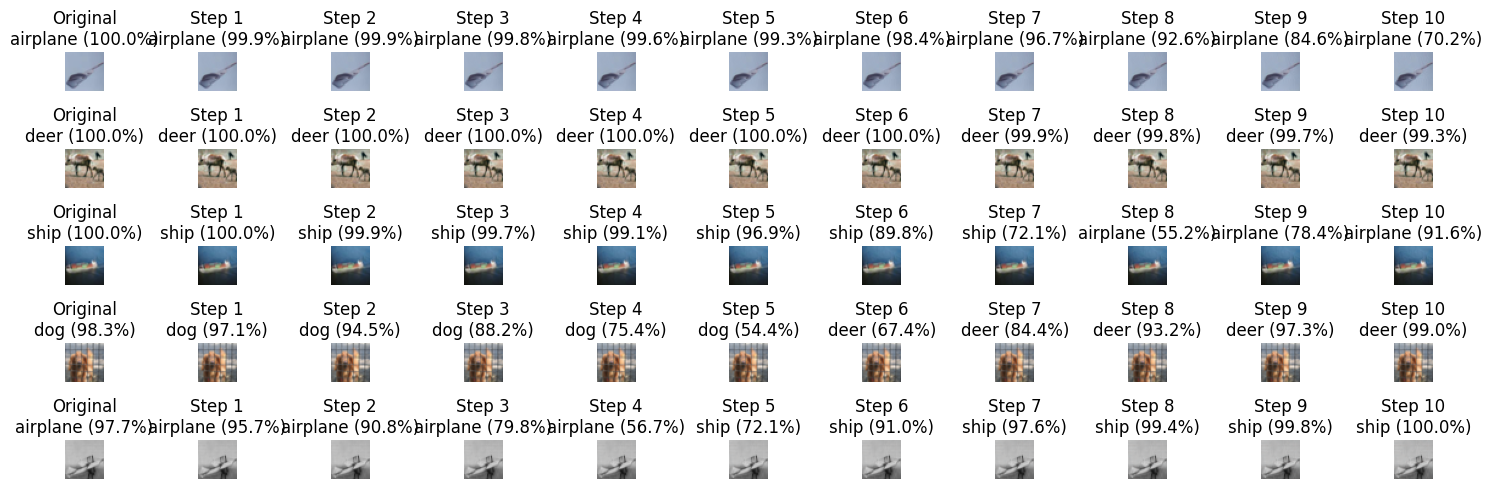

In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Device Setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Define Transforms and Denormalization Function
# -------------------------------
# We use a simple transform (conversion to tensor and normalization).
# (Normalization is applied here with mean=0.5 and std=0.5 so that the pixel values fall in the range [-1, 1].)
norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    norm
])

def denormalize(img_tensor):
    """
    Denormalizes an image tensor that was normalized with mean=0.5 and std=0.5.
    This converts it back to [0,1] range for visualization.
    """
    return img_tensor * 0.5 + 0.5

# -------------------------------
# Load CIFAR-10 Dataset
# -------------------------------
cifar_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=eval_transform
)

# -------------------------------
# Define and Load Teacher Model
# -------------------------------
# Here we define a ResNet18 architecture for CIFAR-10.
teacher = torchvision.models.resnet18(weights=None)
teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
teacher.maxpool = nn.Identity()
num_ftrs = teacher.fc.in_features
teacher.fc = nn.Linear(num_ftrs, 10)

# Path to a checkpoint containing the pre-trained teacher parameters.
teacher_checkpoint = "/notebooks/Resnet18/models/cifar10_best_model"

if os.path.exists(teacher_checkpoint):
    teacher_state = torch.load(teacher_checkpoint, map_location=device)
    teacher.load_state_dict(teacher_state)
else:
    print("Warning: Teacher checkpoint not found. Using an untrained teacher model.")

teacher.to(device)
teacher.eval()  # Freeze teacher during adversarial example generation

# -------------------------------
# Helper Function: Teacher Prediction
# -------------------------------
def get_teacher_prediction(image):
    """
    Runs the teacher model on a single image and returns the predicted label index and its confidence.
    Args:
        image (torch.Tensor): image tensor in normalized form.
    Returns:
        pred (int): predicted label index.
        conf (float): confidence value (softmax probability).
    """
    image = image.to(device)
    with torch.no_grad():
        logits = teacher(image.unsqueeze(0))  # add batch dimension
        probs = torch.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)
    return pred.item(), conf.item()

# -------------------------------
# Define the Adversarial Example Generation Function
# -------------------------------
def generate_adversarial_trajectory(image, teacher, num_steps=10, step_size=0.1):
    """
    Generate a trajectory of adversarial images that target a fixed class throughout all steps.
    
    The fixed target class is defined by evaluating the teacher on the original image and selecting 
    the class corresponding to the second highest logit. This target remains constant during all gradient 
    descent updates.
    
    Args:
      image (torch.Tensor): The original image tensor.
      teacher (torch.nn.Module): The teacher network.
      num_steps (int): Number of gradient descent steps.
      step_size (float): Step size for each gradient descent update.
    
    Returns:
      List[torch.Tensor]: A list of adversarial images (one per step).
    """
    # Create a copy of the image and allow gradient computation.
    x_adv = image.clone().detach().to(device)
    x_adv.requires_grad = True

    adversarial_images = []  # List to record each intermediate adversarial sample

    # Evaluate the teacher on the original image and fix the target class 
    # by selecting the second highest logit.
    with torch.no_grad():
        logits_init = teacher(x_adv.unsqueeze(0))  # Add batch dimension
        sorted_logits, sorted_indices = torch.sort(logits_init, descending=True)
        fixed_target = sorted_indices[0, 1].item()  # Fixed target class

    # Generate adversarial trajectory using the fixed target class.
    for step in range(num_steps):
        logits = teacher(x_adv.unsqueeze(0))
        # Define loss as the negative of the teacher's logit for the fixed target class.
        loss = -logits[0, fixed_target]

        # Zero gradients and compute new gradients.
        teacher.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.zero_()
        loss.backward()

        # Update the adversarial image.
        with torch.no_grad():
            x_adv = x_adv - step_size * x_adv.grad.sign()
        # Prepare for the next iteration.
        x_adv.requires_grad = True
        adversarial_images.append(x_adv.clone().detach())

    return adversarial_images

# -------------------------------
# Expose Hyperparameters for the Adversarial Attack
# -------------------------------
num_attack_steps = 10    # Number of gradient descent steps per sample (number of adversarial images produced).
attack_step_size = .001 # Step size for the gradient descent updates.

# -------------------------------
# Generate Adversarial Trajectories for a Few Samples
# -------------------------------
# Select a few random examples from the dataset for demonstration.
num_samples_to_show = 5
sample_indices = np.random.choice(len(cifar_dataset), num_samples_to_show, replace=False)

original_images = []
trajectories = []  # List of adversarial trajectories (each is a list of images)
sample_labels = []

for idx in sample_indices:
    img, label = cifar_dataset[idx]
    original_images.append(img)
    sample_labels.append(label)
    adv_traj = generate_adversarial_trajectory(img, teacher, num_steps=num_attack_steps, step_size=attack_step_size)
    trajectories.append(adv_traj)

# -------------------------------
# Visualization of Original and Adversarial Examples
# with Teacher Predictions and Confidence Scores
# -------------------------------
# CIFAR-10 class names.
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(num_samples_to_show, num_attack_steps + 1, figsize=(15, 5))

for i in range(num_samples_to_show):
    # Process the original image for visualization.
    orig_img = denormalize(original_images[i]).clamp(0, 1).permute(1, 2, 0).cpu().numpy()
    # Get teacher prediction for the original image.
    pred, conf = get_teacher_prediction(original_images[i])
    teacher_info = f"{cifar_classes[pred]} ({conf*100:.1f}%)"
    
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title("Original\n" + teacher_info)
    axes[i, 0].axis("off")
    
    # Display each adversarial step and plot teacher prediction below.
    for j in range(num_attack_steps):
        adv_img = denormalize(trajectories[i][j]).clamp(0, 1).permute(1, 2, 0).cpu().numpy()
        # Get teacher prediction on the adversarial image.
        pred_adv, conf_adv = get_teacher_prediction(trajectories[i][j])
        teacher_info_adv = f"{cifar_classes[pred_adv]} ({conf_adv*100:.1f}%)"
        
        axes[i, j+1].imshow(adv_img)
        axes[i, j+1].set_title(f"Step {j+1}\n" + teacher_info_adv)
        axes[i, j+1].axis("off")

plt.tight_layout()
plt.show()
